# Simulate PTA with PTA-replicator and Enterprise

In [1]:
from pta_replicator_main.pta_replicator.simulate import load_from_directories
from pta_replicator_main.pta_replicator.simulate import make_ideal
from pta_replicator_main.pta_replicator.white_noise import add_measurement_noise
from pta_replicator_main.pta_replicator.red_noise import add_red_noise, add_gwb
from pta_replicator_main.pta_replicator.deterministic import add_cgw

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import selections
from enterprise.signals import gp_signals
from enterprise.signals import gp_priors
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals.utils import hd_orf
from enterprise.signals import utils
from enterprise_extensions.deterministic import cw_block_circ

import pickle
import dill
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from random import sample, seed

import params_injected
from pulsar_phase import get_psr_phase

%load_ext autoreload
%autoreload 2

## Simulate pulsars

In [2]:
pardir = 'partim/par'
timdir = 'partim/tim'
num_psrs = params_injected.num_psrs
# psrs = load_from_directories(pardir, timdir, num_psrs=num_psrs)
psrs_full = load_from_directories(pardir, timdir, num_psrs=50)
# seed(0)
seed(1443)
psrs = sample(psrs_full, k=num_psrs)

2025-09-03 00:09:47.583 | DEBUG    | pint.toa:__init__:1358 - No pulse number flags found in the TOAs
2025-09-03 00:09:47.584 | DEBUG    | pint.toa:apply_clock_corrections:2200 - Applying clock corrections (include_gps = True, include_bipm = True)
2025-09-03 00:09:47.591 | INFO     | pint.observatory:gps_correction:210 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-09-03 00:09:47.592 | INFO     | pint.observatory:_load_gps_clock:92 - Loading global GPS clock file
2025-09-03 00:09:47.594 | DEBUG    | pint.observatory.clock_file:__init__:799 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-09-03 00:09:47.596 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:456 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/Users/aidengundersen/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/contents) with bogus_last_correction=False
2025-09-03 00:09:47.613 | INFO     | pint.

In [3]:
# store injected parameters
x_inj = {}

# add signals and noise
psr_phases = np.zeros(num_psrs)
for ii, psr in enumerate(psrs):

    ## make ideal
    make_ideal(psr)

    # add efacs
    ## if you use flags, the flags and efac and equad values all need to have the same number of elements
    add_measurement_noise(psr,
                          efac=params_injected.efac_inj, 
                          seed=params_injected.efac_seed + ii)

    ## add red noise
    if params_injected.rn_model:
        add_red_noise(psr,
                      log10_amplitude=params_injected.RN_logamps_inj[ii],
                      spectral_index=params_injected.RN_gammas_inj[ii],
                      components=params_injected.num_modes,
                      seed=params_injected.RN_seed + ii)
        x_inj[f'{psr.name}_red_noise_log10_A'] = params_injected.RN_logamps_inj[ii]
        x_inj[f'{psr.name}_red_noise_gamma'] = params_injected.RN_gammas_inj[ii]
    
    ## add continuous wave
    if params_injected.cw_model:
        ent_psr = psr.to_enterprise()
        psr_dist = ent_psr.pdist[0]
        psr_phase = get_psr_phase(params_injected.CW_params_inj, ent_psr.pos, psr_dist)
        psr_phases[ii] = psr_phase
        psr_params = np.array([psr_dist, psr_phase])
        add_cgw(psr, params_injected.CW_params_inj, psr_params, ent_psr.toas, ent_psr.pos)
        x_inj[f'{psr.name}_cw_p_dist'] = psr_dist
        x_inj[f'{psr.name}_cw_p_phase'] = psr_phase 

    print(ii, psr.name)

# add common CW parameters
if params_injected.cw_model:
    x_inj['cw_cosinc'] = params_injected.cosinc_inj
    x_inj['cw_costheta'] = params_injected.costheta_inj
    x_inj['cw_log10_Mc'] = params_injected.log10_mc_inj
    x_inj['cw_log10_dL'] = params_injected.log10_dist_inj
    x_inj['cw_log10_fgw'] = params_injected.log10_fgw_inj
    x_inj['cw_phase0'] = params_injected.phase0_inj
    x_inj['cw_phi'] = params_injected.gwphi_inj
    x_inj['cw_psi'] = params_injected.psi_inj

2025-09-03 00:09:57.864 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:09:57.864 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:09:57.865 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:09:57.865 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:09:57.880 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:09:57.882 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:09:57.882 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:09:57.882 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:09:57.883 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

0 J0645+5158


2025-09-03 00:09:58.426 | DEBUG    | pint.toa:compute_posvels:2417 - Adding columns ssb_obs_pos ssb_obs_vel obs_sun_pos obs_jupiter_pos obs_saturn_pos obs_venus_pos obs_uranus_pos obs_neptune_pos obs_earth_pos
2025-09-03 00:09:58.492 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:09:58.492 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:09:58.493 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:09:58.493 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:09:58.508 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:09:58.509 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:09:58.509 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:

1 B1855+09


2025-09-03 00:09:58.806 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:09:58.807 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:09:58.808 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:09:58.809 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:09:58.810 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:09:58.811 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:09:58.812 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:09:58.813 | DEBUG    | pint

2 J1843-1113


2025-09-03 00:09:59.262 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:09:59.263 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:09:59.263 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:09:59.263 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:09:59.279 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:09:59.279 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:09:59.280 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:09:59.280 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:09:59.280 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

3 J0557+1551


2025-09-03 00:09:59.654 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:09:59.654 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:09:59.655 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:09:59.655 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:09:59.670 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:09:59.671 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:09:59.671 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:09:59.671 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:09:59.672 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

4 J1730-2304


2025-09-03 00:10:00.009 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:00.009 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:00.010 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:00.010 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:00.010 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. Removing...
2025-09-03 00:10:00.011 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_saturn_pos already exists. Removing...
2025-09-03 00:10:00.011 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_venus_pos already exists. Removing...
2025-09-03 00:10:00.011 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_uranus_pos already exists. Removing...
2025-09-03 00:10:00.012 | DEBUG    | pin

5 J1643-1224


2025-09-03 00:10:00.426 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409705e+09  1.34555717e+11  5.83294451e+10] m
2025-09-03 00:10:00.426 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.427 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.428 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.429 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.430 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.431 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.431 | INFO     | pint.sol

6 J1022+1001


2025-09-03 00:10:00.826 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409706e+09  1.34555717e+11  5.83294451e+10] m
2025-09-03 00:10:00.826 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.828 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.829 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.829 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.830 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.831 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:00.832 | INFO     | pint.sol

7 J1910+1256


2025-09-03 00:10:01.288 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:01.289 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:01.289 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:01.289 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:01.306 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:01.306 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:01.306 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:01.307 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:01.307 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

8 J0740+6620


2025-09-03 00:10:01.676 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:01.676 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:01.677 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:01.678 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:01.697 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:01.697 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:01.698 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:01.698 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:01.699 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

9 J1832-0836


2025-09-03 00:10:02.059 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:02.059 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:02.060 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:02.060 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:02.076 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:02.076 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:02.076 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:02.077 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:02.077 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

10 J1811-2405


2025-09-03 00:10:02.444 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:02.445 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:02.445 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:02.446 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:02.461 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:02.461 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:02.461 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:02.462 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:02.462 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

11 J0030+0451


2025-09-03 00:10:02.834 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:02.834 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:02.834 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:02.835 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:02.850 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:02.850 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:02.850 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:02.851 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:02.851 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

12 J0509+0856


2025-09-03 00:10:03.143 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409706e+09  1.34555717e+11  5.83294451e+10] m
2025-09-03 00:10:03.143 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:03.147 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:03.149 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:03.151 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:03.153 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:03.155 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:03.157 | INFO     | pint.sol

13 J0340+4130


2025-09-03 00:10:03.606 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:03.606 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:03.607 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:03.607 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:03.622 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:03.623 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:03.623 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:03.623 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:03.624 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

14 B1953+29


2025-09-03 00:10:03.995 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:03.995 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:03.996 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:03.996 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:04.012 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:04.012 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:04.013 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:04.013 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:04.013 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

15 J1744-1134


2025-09-03 00:10:04.378 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:04.380 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:04.380 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:04.381 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:04.398 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:04.399 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:04.399 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:04.400 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:04.400 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

16 B1937+21


2025-09-03 00:10:04.734 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:04.734 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:04.735 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:04.750 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:04.750 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:04.750 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:04.751 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:04.751 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. Removing...
2025-09-03 00:10:04.751 | DEBUG    | pint.toa:compute_posvels:2360 - Column o

17 J1719-1438


2025-09-03 00:10:05.234 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:05.234 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:05.234 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:05.235 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:05.250 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:05.251 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:05.251 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:05.251 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:05.251 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

18 J0605+3757


2025-09-03 00:10:05.626 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:05.626 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:05.627 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:05.627 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:05.642 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:05.642 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:05.643 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:05.643 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:05.643 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

19 J1903+0327


In [4]:
if params_injected.gwb_model:
        add_gwb(psrs,
                log10_amplitude=params_injected.GWB_logamp_inj,
                spectral_index=params_injected.GWB_gamma_inj,
                seed=params_injected.GWB_seed)
        x_inj['log10_A_gw'] = params_injected.GWB_logamp_inj
        x_inj['gamma_gw'] = params_injected.GWB_gamma_inj

2025-09-03 00:10:05.950 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-09-03 00:10:05.950 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-09-03 00:10:05.951 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-09-03 00:10:05.951 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-09-03 00:10:05.974 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-09-03 00:10:05.975 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-09-03 00:10:05.975 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-09-03 00:10:05.976 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-09-03 00:10:05.976 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

In [5]:
# fit timing model
for psr in psrs:
    print(psr.name)
    psr.fit()

2025-09-03 00:10:08.293 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0645+5158


2025-09-03 00:10:09.136 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.00097714765568796
2025-09-03 00:10:09.515 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


B1855+09


2025-09-03 00:10:10.348 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.00039986081953607977
2025-09-03 00:10:10.732 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1843-1113


2025-09-03 00:10:11.568 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.00020120584696148303
2025-09-03 00:10:11.955 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0557+1551


2025-09-03 00:10:12.788 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.000507101626948725
2025-09-03 00:10:13.170 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1730-2304


2025-09-03 00:10:14.006 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0005902736964391031
2025-09-03 00:10:14.062 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1643-1224


2025-09-03 00:10:14.984 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0011993174138269502
2025-09-03 00:10:15.041 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1022+1001


2025-09-03 00:10:15.871 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0006523104161534343
2025-09-03 00:10:15.924 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1910+1256


2025-09-03 00:10:16.754 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0004164691399997089
2025-09-03 00:10:16.815 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0740+6620


2025-09-03 00:10:17.640 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0011387260335861127
2025-09-03 00:10:17.693 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1832-0836


2025-09-03 00:10:18.524 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.001604621347007118
2025-09-03 00:10:18.578 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1811-2405


2025-09-03 00:10:19.412 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0003620379881529301
2025-09-03 00:10:19.469 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0030+0451


2025-09-03 00:10:20.295 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0014100184586178788
2025-09-03 00:10:20.678 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0509+0856


2025-09-03 00:10:21.510 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.00036947435858025734
2025-09-03 00:10:21.565 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0340+4130


2025-09-03 00:10:22.400 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0007574599289683903
2025-09-03 00:10:22.455 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


B1953+29


2025-09-03 00:10:23.285 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0020427344887030408
2025-09-03 00:10:23.673 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1744-1134


2025-09-03 00:10:24.512 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.00029571820918117275
2025-09-03 00:10:24.565 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


B1937+21


2025-09-03 00:10:25.405 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.00031419862489821815
2025-09-03 00:10:25.460 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1719-1438


2025-09-03 00:10:26.295 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.00017146284075530982
2025-09-03 00:10:26.680 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0605+3757


2025-09-03 00:10:27.502 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0003221821033370098
2025-09-03 00:10:27.879 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1903+0327


2025-09-03 00:10:28.717 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0006639440460840529


J0645+5158


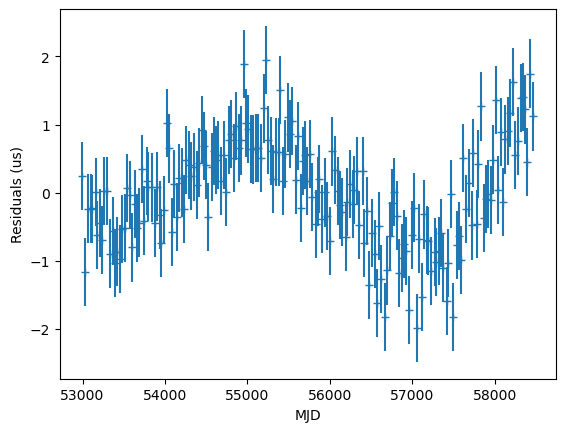

B1855+09


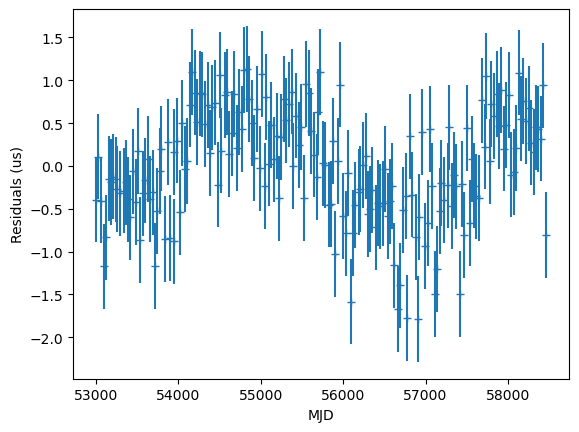

J1843-1113


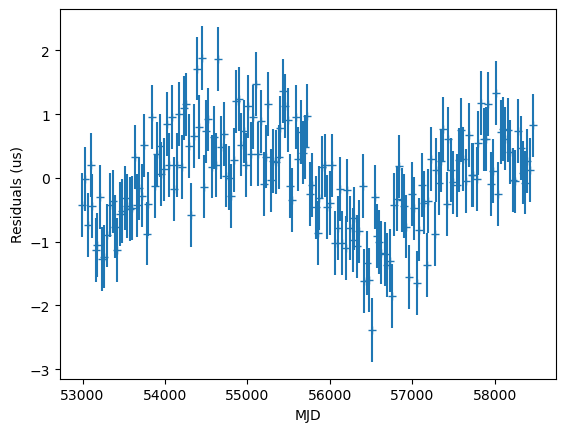

J0557+1551


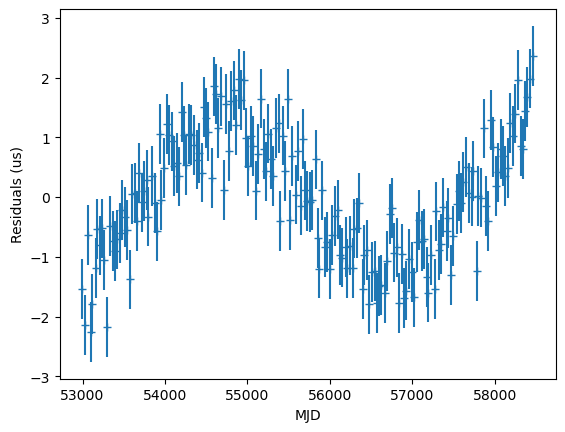

J1730-2304


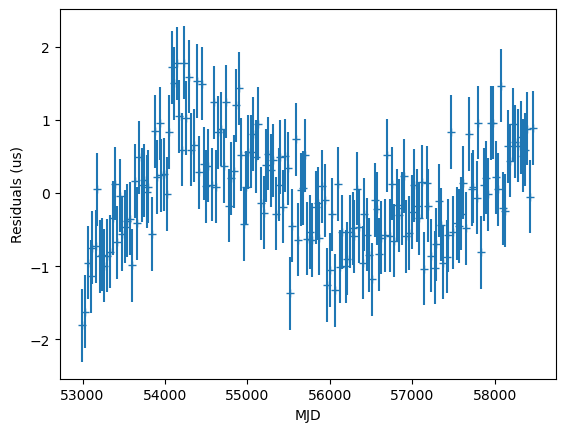

J1643-1224


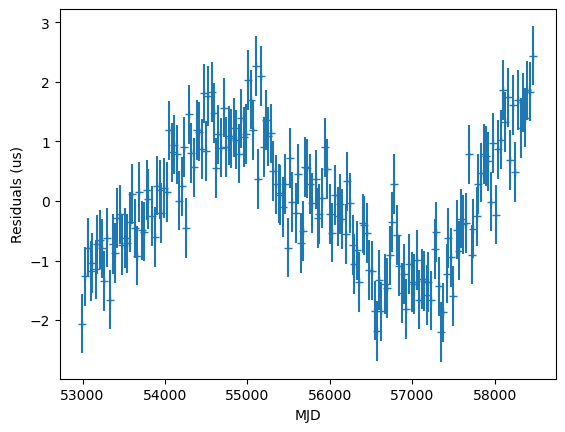

J1022+1001


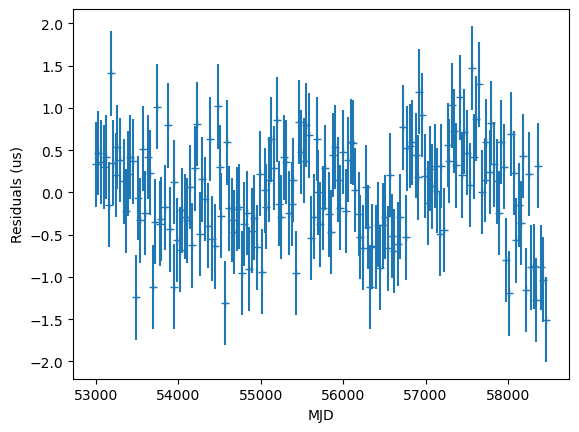

J1910+1256


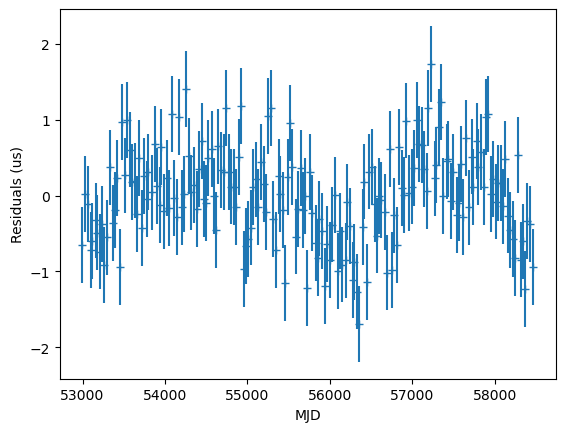

J0740+6620


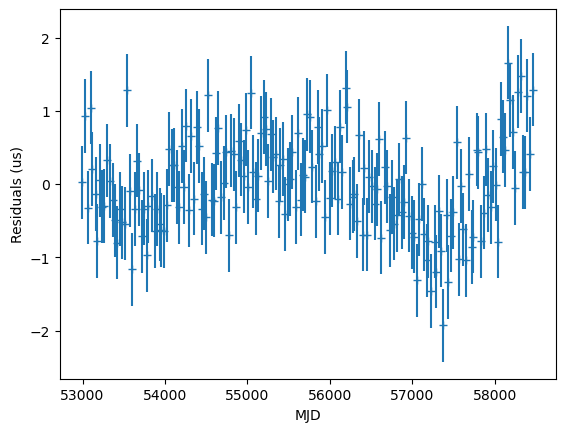

J1832-0836


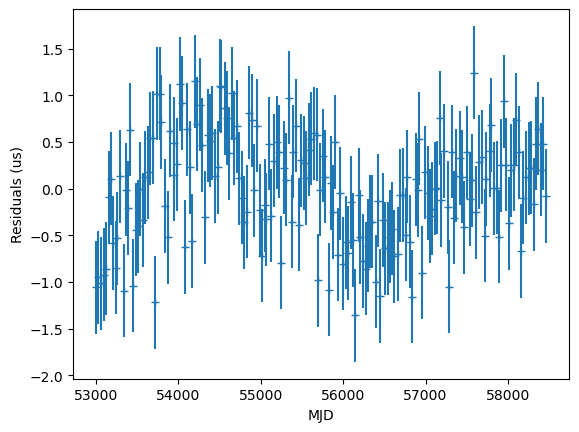

J1811-2405


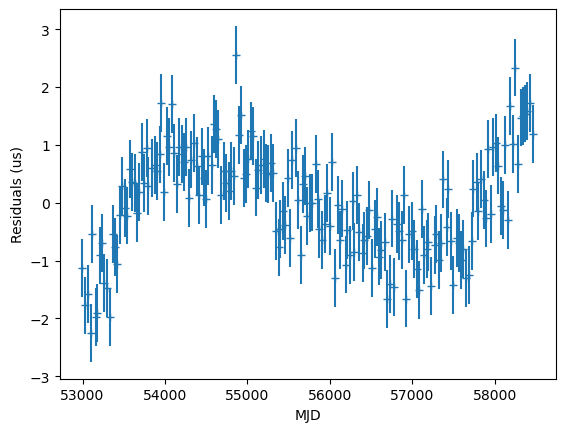

J0030+0451


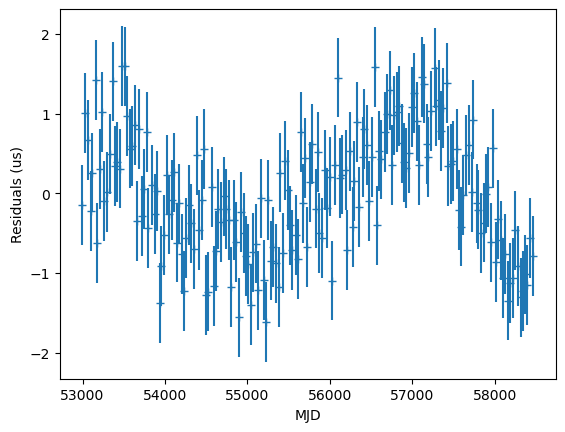

J0509+0856


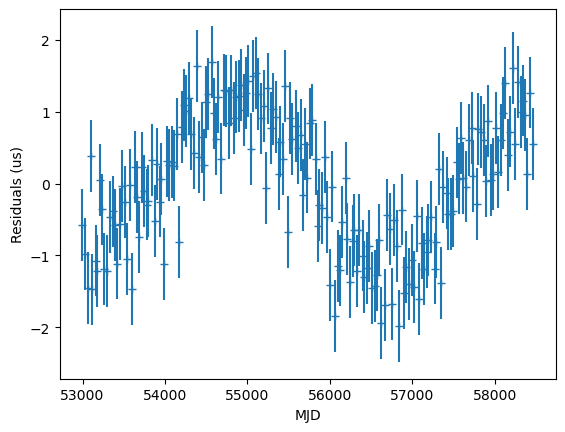

J0340+4130


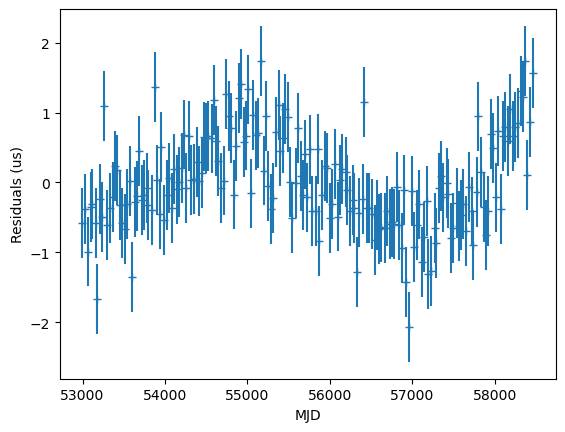

B1953+29


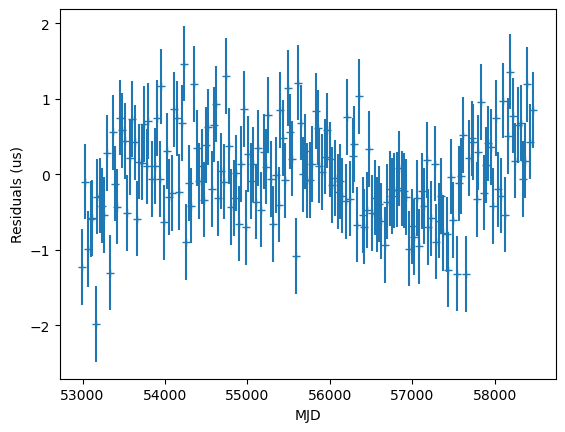

J1744-1134


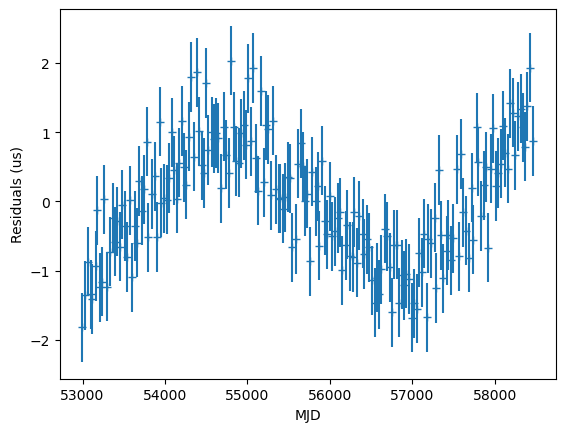

B1937+21


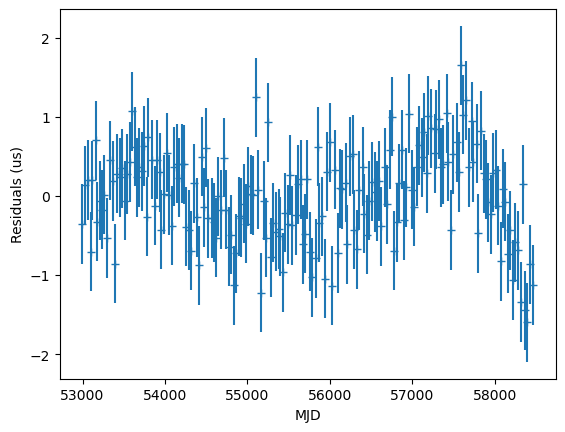

J1719-1438


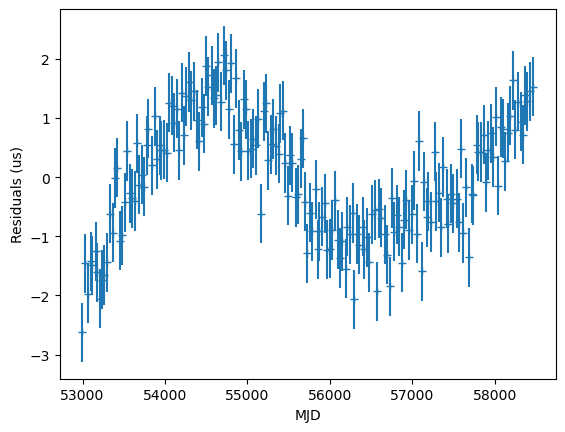

J0605+3757


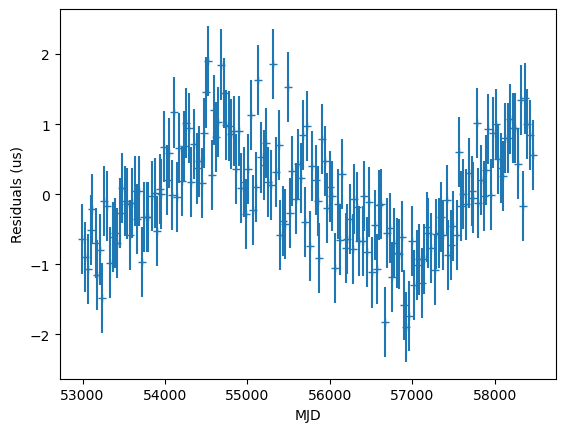

J1903+0327


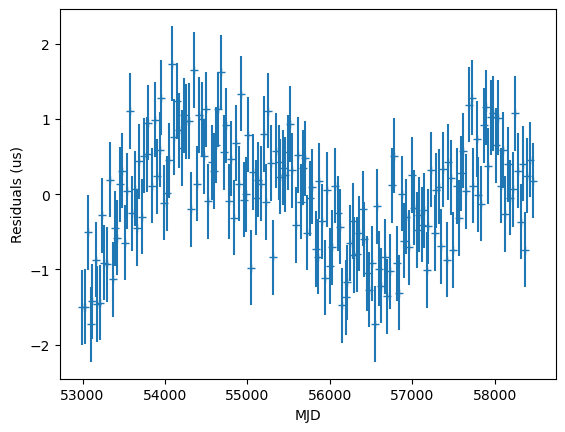

In [6]:
for psr in psrs:
    print(psr.name)
    plt.errorbar(
        psr.toas.get_mjds(),
        psr.residuals.time_resids.to_value("us"),
        psr.residuals.get_data_error().to_value("us"),
        marker="+",
        ls="",
    )
    plt.xlabel("MJD")
    plt.ylabel("Residuals (us)")
    plt.show()

In [7]:
# convert to enterprise type pulsars
ent_psrs = []
for psr in psrs:
    ent_psrs.append(psr.to_enterprise())

2025-09-03 00:10:30.806 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:30.825 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-09-03 00:10:30.825 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-09-03 00:10:31.310 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:31.329 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-09-03 00:10:31.329 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-09-03 00:10:31.799 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-09-03 00:10:31.817 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-09-03 00:10:31.818 | DEBUG    | pint.models.astrometry:ssb_

In [8]:
# save Enterprise pulsar objects
with open('data/enterprise_pulsars.pkl', 'wb') as f:
    pickle.dump(ent_psrs, f)

In [9]:
for psr in ent_psrs:
    print(psr.pdist)

(1.0, 0.2)
(0.9, 0.2)
(1.0, 0.2)
(1.0, 0.2)
(0.51, 0.1)
(0.42, 0.09)
(0.52, 0.09)
(1.95, 0.39)
(1.0, 0.2)
(1.0, 0.2)
(1.0, 0.2)
(0.28, 0.1)
(1.0, 0.2)
(1.0, 0.2)
(5.39, 1.1)
(0.42, 0.02)
(5.0, 2.0)
(1.0, 0.2)
(1.0, 0.2)
(1.0, 0.2)


## Make PTA

In [10]:
# use built in backend selection
backend = selections.Selection(selections.by_backend)

# EFAC parameter
if params_injected.wn_model:
    efac_param = parameter.Uniform(0.5, 3.0)
else:
    efac_param = params_injected.efac_inj

# make white noise
wn = white_signals.MeasurementNoise(efac=efac_param,
                                    log10_t2equad=-1000, 
                                    selection=backend)

In [11]:
# red noise
if params_injected.rn_model:
    logamp_param = parameter.Uniform(-30., -10.)
    gamma_param = parameter.Uniform(0.1, 20.)

    # get power law in prior
    powlaw = gp_priors.powerlaw(log10_A=logamp_param, gamma=gamma_param)

    # make red noise
    rn = gp_signals.FourierBasisGP(spectrum=powlaw, components=params_injected.num_modes)

In [12]:
# GWB
if params_injected.gwb_model:
    log10_A_gw = parameter.Uniform(-30., -10.)('log10_A_gw')
    gamma_gw = parameter.Uniform(0.1, 20.)('gamma_gw')
    cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
    gw = gp_signals.FourierBasisCommonGP(spectrum=cpl, orf=hd_orf(),
                                         components=params_injected.num_modes, name='gw')

In [13]:
# make CW signal
if params_injected.cw_model:
    cw = cw_block_circ(dist_prior='log-uniform', psrTerm=True, tref=params_injected.tref)

In [14]:
# make timing model
tm = gp_signals.TimingModel(use_svd=True)

In [15]:
# make model and PTA object
model = tm + wn
if params_injected.rn_model:
    model += rn
if params_injected.gwb_model:
    model += gw
if params_injected.cw_model:
    model += cw
    
pta = signal_base.PTA([model(psr) for psr in ent_psrs])

In [16]:
# save PTA object
with open('data/pta.pkl', 'wb') as f:
    dill.dump(pta, f)

print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J0645+5158_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J0645+5158_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J0645+5158_gw                            FourierBasisCommonGP           2                   

params:
log10_A_gw:Uniform(pmin=-30.0, pmax=-10.0)                                                
gamma_gw:Uniform(pmin=0.1, pmax=20.0)                                                     
__________________________________________________________________________________________
B1855+09_linear_timing_model_svd         TimingModel                    0                   

params:
_______

In [17]:
# save data
Fs = np.array([basis[:, 8:] for basis in pta.get_basis()])
Ms = np.array([ent_psr.Mmat for ent_psr in ent_psrs])
Ns = np.array([np.diag(ent_psr.toaerrs**2.) for ent_psr in ent_psrs])
toas = np.array([ent_psr.toas for ent_psr in ent_psrs])
residuals = np.array([ent_psr.residuals for ent_psr in ent_psrs])
psr_pos = np.array([ent_psr.pos for ent_psr in ent_psrs])
psr_names = np.array([ent_psr.name for ent_psr in ent_psrs])
psr_dists = np.array([[psr.pdist[0], psr.pdist[1]] for psr in ent_psrs]).T

# save data in dictionary
data_dict = {}
data_dict['Fs'] = Fs
data_dict['Ms'] = Ms
data_dict['Ns'] = Ns
data_dict['toas'] = toas
data_dict['residuals'] = residuals
data_dict['psr_pos'] = psr_pos
data_dict['psr_names'] = psr_names
data_dict['psr_dists'] = psr_dists
data_dict['psr_phases'] = psr_phases
data_dict['x_inj'] = x_inj
np.savez_compressed('data/data_dict.npz', **data_dict)

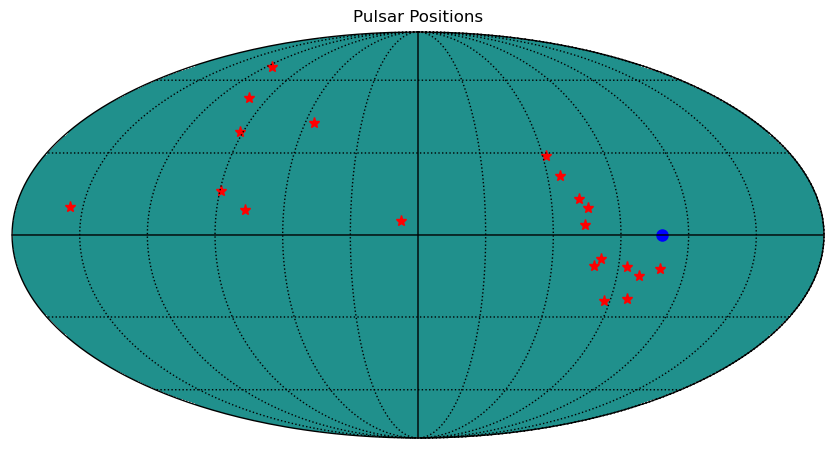

In [18]:
# plot pulsar positions
theta_psr = np.arccos(psr_pos[:, 2])  # z = cos(theta)
phi_psr = np.arctan2(psr_pos[:, 1], psr_pos[:, 0])  # atan2(y, x)
phi_psr = np.mod(phi_psr, 2 * np.pi)


# Convert to HEALPix map
nside = 64
npix = hp.nside2npix(nside)

# Plot
hp.mollview(np.zeros(hp.nside2npix(64)), title="Pulsar Positions", cbar=False)
hp.projplot(theta_psr, phi_psr, 'r*', markersize=8)
hp.projplot(params_injected.gwtheta_inj, params_injected.gwphi_inj, 'bo', markersize=8)
hp.graticule()
plt.show()